# Introduction

This notebook aims to predict credict socre from the dataset which labeled sample as good/standard/poor account. Besieds, this notebook will also try to measure the uncertainty of the prediction, like providing a predictive interval or possible predictive set. NGBoost and Conformal Prediction will be used below.

# Dependencies

In [78]:
import numpy as np
import pandas as pd
import math
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.utils import to_categorical
import os
from scipy.stats import norm

In [79]:
import os
print(os.getcwd())


d:\Msc data science\sem 4\web project data science\Score_Sense_django\Score_Sense\webapp


In [80]:
import os

# Construct the relative path
dataset_path = os.path.join('data', 'train.csv')
df = pd.read_csv(dataset_path, low_memory=False)
df.head(5)


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


# Preprocess

In [81]:
#Drop Irrelevant Features
df.drop(["Name", "SSN", "ID", "Customer_ID"], axis=1, inplace=True, errors="ignore")

In [82]:
print("Credit Score Class Distribution")
print("Poor: ",df['Credit_Score'].value_counts()['Poor'])
print("Standard: ",df['Credit_Score'].value_counts()['Standard'])
print("Good: ",df['Credit_Score'].value_counts()['Good'])

Credit Score Class Distribution
Poor:  28998
Standard:  53174
Good:  17828


In [83]:
def text_to_months(text):
    if pd.isna(text):
        return 0
    # Split the text into individual words
    words = text.split()

    # Extract the years and months
    years = int(words[0])
    months = int(words[3]) if len(words) > 3 else 0

    # Calculate the total number of months
    total_months = years * 12 + months

    return total_months

df['Credit_History_Age'] = df['Credit_History_Age'].apply(text_to_months)

In [84]:
df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,January,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,_,809.98,26.822620,265,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,February,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,31.944960,0,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,March,-500,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,28.609352,267,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,April,23,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,31.377862,268,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,May,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",...,Good,809.98,24.797347,269,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [85]:
def replace_special_character(text):
        if "NM" in str(text):
            return "No"

        if "payments" in str(text) or "_" not in str(text):
            return text

        clean_text = str(text).replace("_", "")
        try:
            clean_text = pd.to_numeric(clean_text)
        except ValueError as e:
            clean_text = np.nan
        return np.nan if clean_text == "nan" or clean_text == "" else clean_text

In [86]:
df['Age'] = pd.to_numeric(df['Age'].apply(replace_special_character))
df['Annual_Income'] = pd.to_numeric(df['Annual_Income'].apply(replace_special_character))
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'].apply(replace_special_character))
df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'].apply(replace_special_character))
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'].apply(replace_special_character))
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'].apply(replace_special_character))
df['Monthly_Balance'] =  pd.to_numeric(df['Monthly_Balance'].apply(replace_special_character))
df['Num_of_Loan'] =  pd.to_numeric(df['Num_of_Loan'].apply(replace_special_character))

In [87]:
def remove_outliers(x,f):
    try:
        # Convert to numeric
        x = pd.to_numeric(x, errors='raise')
        
        # Handle negative values
        if x < 0:
            return np.nan
        else:
            if f == 'age':
                if x>=100:
                    return np.nan
                else:
                    return x
            else:
                return x
    except ValueError:
        return np.nan

df['Age'] = df.apply(lambda x: remove_outliers(x['Age'], 'age'), axis=1)
df['Num_of_Delayed_Payment'] = df.apply(lambda x: remove_outliers(x['Num_of_Delayed_Payment'], 'none'), axis=1)
df['Num_of_Loan'] = df.apply(lambda x: remove_outliers(x['Num_of_Loan'], 'none'), axis=1)

In [88]:
df['Annual_Income'].fillna(df['Annual_Income'].median())
df['Changed_Credit_Limit'].fillna(df['Changed_Credit_Limit'].median())
df['Outstanding_Debt'].fillna(df['Outstanding_Debt'].median())
df['Monthly_Inhand_Salary'].fillna(df['Monthly_Inhand_Salary'].median())
df['Num_of_Delayed_Payment'].fillna(df['Num_of_Delayed_Payment'].median())
df['Num_Credit_Inquiries'].fillna(df['Num_Credit_Inquiries'].median())
df['Amount_invested_monthly'].fillna(df['Amount_invested_monthly'].median())
df['Monthly_Balance'].fillna(df['Monthly_Balance'].median())
df = df.dropna(subset=['Num_of_Loan'])

In [89]:
df = df.dropna(subset=['Type_of_Loan'])

In [90]:
Type_of_Loan=df['Type_of_Loan'].str.split(',\s*and\s*|\s*,\s*')
Type_of_Loan = Type_of_Loan.explode()
loan_type_label = Type_of_Loan.unique()

In [91]:
def replace_and(text):
        clean_text = str(text).replace(" and", "")
        return np.nan if clean_text == "nan" else clean_text

In [92]:
df['Type_of_Loan'] = df['Type_of_Loan'].apply(replace_and)
for loan_type in loan_type_label:
    df['Count_' + loan_type] = df['Type_of_Loan'].apply(lambda x: x.split(', ').count(loan_type))

In [93]:
df.drop(['Num_of_Loan'], axis=1, inplace=True, errors="ignore")

In [94]:
#Checking the value in count type of loan
df.loc[df['Type_of_Loan'] == 'Auto Loan, Auto Loan']

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Type_of_Loan,Delay_from_due_date,...,Credit_Score,Count_Auto Loan,Count_Credit-Builder Loan,Count_Personal Loan,Count_Home Equity Loan,Count_Not Specified,Count_Mortgage Loan,Count_Student Loan,Count_Debt Consolidation Loan,Count_Payday Loan
912,January,39.0,Manager,30536.62,2430.718333,6,6,7,"Auto Loan, Auto Loan",19,...,Standard,2,0,0,0,0,0,0,0,0
913,February,39.0,Manager,30536.62,2430.718333,6,6,7,"Auto Loan, Auto Loan",19,...,Standard,2,0,0,0,0,0,0,0,0
914,March,39.0,Manager,30536.62,2430.718333,6,6,7,"Auto Loan, Auto Loan",19,...,Standard,2,0,0,0,0,0,0,0,0
915,April,39.0,_______,30536.62,NaN,6,6,7,"Auto Loan, Auto Loan",19,...,Standard,2,0,0,0,0,0,0,0,0
916,May,39.0,Manager,30536.62,2430.718333,6,6,7,"Auto Loan, Auto Loan",19,...,Poor,2,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89874,March,26.0,Scientist,53878.98,4328.915000,4,3,5,"Auto Loan, Auto Loan",11,...,Good,2,0,0,0,0,0,0,0,0
89875,April,26.0,Scientist,53878.98,NaN,4,3,5,"Auto Loan, Auto Loan",11,...,Standard,2,0,0,0,0,0,0,0,0
89876,May,26.0,Scientist,53878.98,4328.915000,4,3,5,"Auto Loan, Auto Loan",11,...,Standard,2,0,0,0,0,0,0,0,0
89877,June,26.0,_______,53878.98,4328.915000,4,3,5,"Auto Loan, Auto Loan",11,...,Standard,2,0,0,0,0,0,0,0,0


In [95]:
df.drop(["Type_of_Loan"], axis=1, inplace=True, errors="ignore")

In [96]:
df.dropna(inplace=True)
df["Age"] = pd.to_numeric(df["Age"])
df["Annual_Income"] = pd.to_numeric(df["Annual_Income"])
df["Num_of_Delayed_Payment"] = pd.to_numeric(df["Num_of_Delayed_Payment"])
df["Changed_Credit_Limit"] = pd.to_numeric(df["Changed_Credit_Limit"])
df["Outstanding_Debt"] = pd.to_numeric(df["Outstanding_Debt"])
df["Amount_invested_monthly"] = pd.to_numeric(df["Amount_invested_monthly"])
df["Monthly_Balance"] = pd.to_numeric(df["Monthly_Balance"])

In [97]:
df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Score,Count_Auto Loan,Count_Credit-Builder Loan,Count_Personal Loan,Count_Home Equity Loan,Count_Not Specified,Count_Mortgage Loan,Count_Student Loan,Count_Debt Consolidation Loan,Count_Payday Loan
0,January,23.0,Scientist,19114.12,1824.843333,3,4,3,3,7.0,...,Good,1,1,1,1,0,0,0,0,0
6,July,23.0,Scientist,19114.12,1824.843333,3,4,3,3,8.0,...,Good,1,1,1,1,0,0,0,0,0
7,August,23.0,Scientist,19114.12,1824.843333,3,4,3,3,6.0,...,Standard,1,1,1,1,0,0,0,0,0
8,January,28.0,_______,34847.84,3037.986667,2,4,6,3,4.0,...,Standard,0,1,0,0,0,0,0,0,0
9,February,28.0,Teacher,34847.84,3037.986667,2,4,6,7,1.0,...,Good,0,1,0,0,0,0,0,0,0


In [98]:
df.drop(df[df['Occupation'] == '_______'].index, inplace = True)
df.drop(df[df['Payment_of_Min_Amount'] == 'NM'].index, inplace = True)

In [99]:
df.drop(df[df['Credit_Mix'] == '_'].index, inplace = True)

In [100]:
df.drop(df[df['Payment_Behaviour'] == '!@9#%8'].index, inplace = True)

In [101]:
print('Number of Rows with Missing Values: ', df.isnull().any(axis=1).sum())
print('Number of Rows: ', df.any(axis=1).sum())

Number of Rows with Missing Values:  0
Number of Rows:  35688


In [102]:
print("Credit Score Class Distribution")
print("Poor: ",df['Credit_Score'].value_counts()['Poor'])
print("Standard: ",df['Credit_Score'].value_counts()['Standard'])
print("Good: ",df['Credit_Score'].value_counts()['Good'])

Credit Score Class Distribution
Poor:  11139
Standard:  18956
Good:  5593


In [103]:
df = pd.get_dummies(df, columns=['Occupation', 'Credit_Mix','Payment_of_Min_Amount'], dtype=int)

In [104]:
df['Spent Amount Payment_Behaviour'] = df['Payment_Behaviour'].str.extract(r'(\w+)_spent')
df['Value Amount Payment_Behaviour'] = df['Payment_Behaviour'].str.extract(r'_spent_(\w+)_value')

In [105]:
df.drop(["Payment_Behaviour"], axis=1, inplace=True, errors="ignore")

In [106]:
spent_mapping = {'Low': 0, 'High': 1}
value_mapping = {'Small': 0, 'Medium': 1, 'Large': 2}
month_mapping = {'January': 1,'February': 2,'March': 3,'April': 4,'May': 5,'June': 6,'July': 7,'August': 8,'September': 9,'October': 10,'November': 11,'December': 12}

# Encode the categories to integers
df['Spent Amount Payment_Behaviour'] = df['Spent Amount Payment_Behaviour'].map(spent_mapping)
df['Value Amount Payment_Behaviour'] = df['Value Amount Payment_Behaviour'].map(value_mapping)
df['Month'] = df['Month'].map(month_mapping)

For giving a credit score rather than just a credit category, map the 'Good' and 'Standard' as a same label.


In [107]:
X = df.loc[:, df.columns != "Credit_Score"]
y = df["Credit_Score"]

# Model
## NGBoost
### Training

In [108]:
X_train, X_test, y_train_label, y_test_label = train_test_split(X, y, test_size=0.25, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)


score_mapping = {'Poor': 0, 'Standard': 1, 'Good': 1}
y_train = y_train_label.map(score_mapping)
y_test = y_test_label.map(score_mapping)

In [109]:
y_train_label

42458    Standard
37187        Good
14389    Standard
98893        Poor
51884    Standard
           ...   
47162    Standard
17289    Standard
31363    Standard
2357     Standard
44186    Standard
Name: Credit_Score, Length: 26766, dtype: object

In [110]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli
from ngboost.scores import LogScore

# NGB is trying to fit the distribution of the response. I try to fit a Bernoulli distributio for good/bad in this case.
# In fact, we can do further assumptions like assumming logit(p) ~ Normal. It may not be so reasonable but be acceptable for NGB.
ngb = NGBClassifier(Dist=Bernoulli, Score=LogScore, verbose=True)

ngb.fit(X_train, y_train)

[iter 0] loss=0.6210 val_loss=0.0000 scale=2.0000 norm=4.0000
[iter 100] loss=0.4341 val_loss=0.0000 scale=2.0000 norm=3.5325
[iter 200] loss=0.4195 val_loss=0.0000 scale=0.5000 norm=0.9046
[iter 300] loss=0.4182 val_loss=0.0000 scale=0.5000 norm=0.9081
[iter 400] loss=0.4178 val_loss=0.0000 scale=0.0005 norm=0.0009


NGBClassifier(random_state=RandomState(MT19937) at 0x153F104C840)

In [111]:
predicted_probs = ngb.predict_proba(X_test)

predicted_intervals = ngb.pred_dist(X_test).params
print('Prediction prabability of first ten samples: ',predicted_probs)
roc_auc = roc_auc_score(y_test, predicted_probs[:, 1])
print('The AUC on the test set is: ',roc_auc)

Prediction prabability of first ten samples:  [[0.1052993  0.8947007 ]
 [0.1172107  0.8827893 ]
 [0.14679918 0.85320082]
 ...
 [0.1052993  0.8947007 ]
 [0.42228381 0.57771619]
 [0.67084485 0.32915515]]
The AUC on the test set is:  0.860025965936044


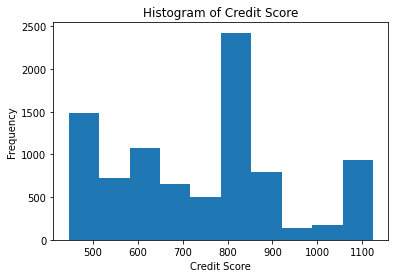

First ten intervals of credit scores: [[842, 846, 851], [828, 833, 837], [799, 803, 807], [842, 846, 851], [977, 984, 992], [842, 846, 851], [842, 847, 851], [805, 809, 813], [717, 720, 724], [842, 846, 851]]


In [112]:
#assume asymptotically normal to construct the intervals
n = len(X_train)
prob1 = [prob[1] for prob in predicted_probs]
upper_probs = [prob[1]+1.96*math.sqrt(prob[1]*prob[0]/n) if prob[1]+1.96*math.sqrt(prob[1]*prob[0]/n) < 1 else 0.99 for prob in predicted_probs]
lower_probs = [prob[1]-1.96*math.sqrt(prob[1]*prob[0]/n) if prob[1]-1.96*math.sqrt(prob[1]*prob[0]/n) > 0 else 0.01 for prob in predicted_probs]

# A method of mapping odds ratio to credit score, just a sample demo here.
score = [int(600+80*(math.log2(prob/(1-prob)))) for prob in prob1]
upper_score = [int(600+80*(math.log2(prob/(1-prob)))) for prob in upper_probs]
lower_score = [int(600+80*(math.log2(prob/(1-prob)))) for prob in lower_probs]
plt.hist(score)
plt.title('Histogram of Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.show()

score_interval = [[ls, s, us] for (ls,s,us) in zip(lower_score, score, upper_score)]
print('First ten intervals of credit scores:',score_interval[:10])

### Analysis

Width of first ten credit score intervals [(9, 'Standard'), (9, 'Standard'), (8, 'Good'), (9, 'Standard'), (15, 'Standard'), (9, 'Standard'), (9, 'Standard'), (8, 'Standard'), (7, 'Standard'), (9, 'Standard')]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


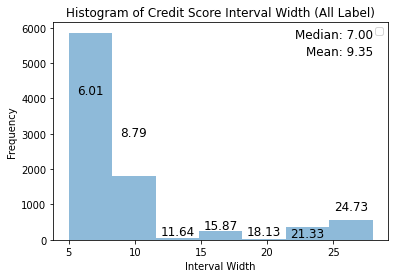

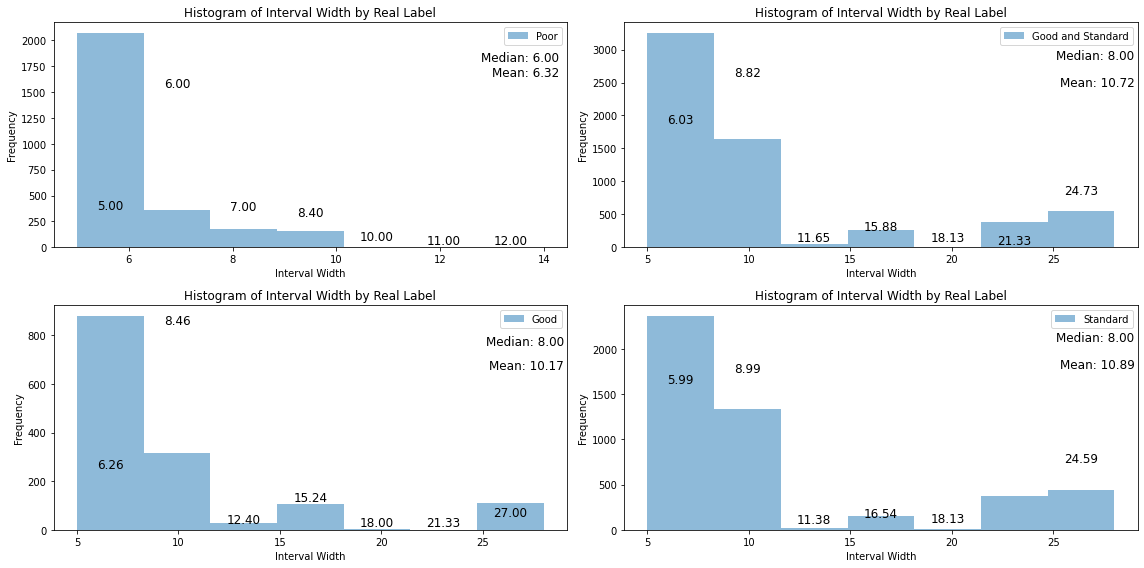

In [113]:
score_width = [(x[2]-x[0],y) for (x,y) in zip(score_interval,y_test_label)]
print('Width of first ten credit score intervals',score_width[:10])

all_data = np.array([value for value, label in score_width])
good_data = np.array([value for value, label in score_width if label == 'Good'])
standard_data = np.array([value for value, label in score_width if label == 'Standard'])
bad_data = np.array([value for value, label in score_width if label == 'Poor'])
good_and_standard_data = np.array([value for value, label in score_width if label in ['Good', 'Standard']])

median_value = [np.median(all_data),np.median(good_data),np.median(standard_data),np.median(bad_data),np.median(good_and_standard_data)]
mean_value = [np.mean(all_data),np.mean(good_data),np.mean(standard_data),np.mean(bad_data),np.mean(good_and_standard_data)]


bins_all = np.linspace(min(all_data), max(all_data), 8)
bin_means_all = []
bin_counts_all = []
for i in range(len(bins_all) - 1):
    bin_data_all = all_data[(all_data >= int(bins_all[i])) & (all_data < int(bins_all[i+1]))]
    bin_mean_all = np.mean(bin_data_all) if len(bin_data_all) > 0 else np.nan
    bin_means_all.append(bin_mean_all)
    bin_counts_all.append(len(bin_data_all))

bins_good = np.linspace(min(good_data), max(good_data), 8)
bin_means_good = []
bin_counts_good = []
for i in range(len(bins_good) - 1):
    bin_data_good = good_data[(good_data >= int(bins_good[i])) & (good_data < int(bins_good[i+1]))]
    bin_mean_good = np.mean(bin_data_good) if len(bin_data_good) > 0 else np.nan
    bin_means_good.append(bin_mean_good)
    bin_counts_good.append(len(bin_data_good))

    
bins_bad = np.linspace(min(bad_data), max(bad_data), 8)
bin_means_bad = []
bin_counts_bad = []
for i in range(len(bins_bad) - 1):
    bin_data_bad = bad_data[(bad_data >= int(bins_bad[i])) & (bad_data < int(bins_bad[i+1]))]
    bin_mean_bad = np.mean(bin_data_bad) if len(bin_data_bad) > 0 else np.nan
    bin_means_bad.append(bin_mean_bad)
    bin_counts_bad.append(len(bin_data_bad))
    
bins_standard = np.linspace(min(standard_data), max(standard_data), 8)
bin_means_standard = []
bin_counts_standard = []
for i in range(len(bins_standard) - 1):
    bin_data_standard = standard_data[(standard_data >= int(bins_standard[i])) & (standard_data < int(bins_standard[i+1]))]
    bin_mean_standard = np.mean(bin_data_standard) if len(bin_data_standard) > 0 else np.nan
    bin_means_standard.append(bin_mean_standard)
    bin_counts_standard.append(len(bin_data_standard))
    
bins_good_and_standard = np.linspace(min(good_and_standard_data), max(good_and_standard_data), 8)
bin_means_good_and_standard = []
bin_counts_good_and_standard = []
for i in range(len(bins_good_and_standard) - 1):
    bin_data_good_and_standard = good_and_standard_data[(good_and_standard_data >= int(bins_good_and_standard[i])) & (good_and_standard_data < int(bins_good_and_standard[i+1]))]
    bin_mean_good_and_standard = np.mean(bin_data_good_and_standard) if len(bin_data_good_and_standard) > 0 else np.nan
    bin_means_good_and_standard.append(bin_mean_good_and_standard)
    bin_counts_good_and_standard.append(len(bin_data_good_and_standard))


plt.hist(all_data, bins=7, alpha=0.5)
plt.title('Histogram of Credit Score Interval Width (All Label)')
plt.text(28,6000,f'Median: {median_value[0]:.2f}', color='black', fontsize=12,  ha='right', va='top')
plt.text(28,5500, f'Mean: {mean_value[0]:.2f}', color='black', fontsize=12,  ha='right', va='top')
plt.xlabel('Interval Width')
plt.ylabel('Frequency')

for i, mean in enumerate(bin_means_all):
    if not np.isnan(mean):
        x_pos = (bins_all[i] + bins_all[i+1]) / 2
        y_pos = bin_counts_all[i] * 0.9
        plt.text(x_pos, y_pos, f'{mean:.2f}', color='black', fontsize=12, ha='center', va='bottom')
plt.legend()
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(16, 8))
axs[1, 0].hist(good_data, bins=7, alpha=0.5, label='Good')
axs[1, 0].text(29,800,f'Median: {median_value[1]:.2f}', color='black', fontsize=12,  ha='right', va='top')
axs[1, 0].text(29,700, f'Mean: {mean_value[1]:.2f}', color='black', fontsize=12,  ha='right', va='top')
axs[1, 0].set_xlabel('Interval Width')
axs[1, 0].set_ylabel('Frequency')
for i, mean in enumerate(bin_means_good):
    if not np.isnan(mean):
        x_pos = (bins_good[i] + bins_good[i+1]) / 2
        y_pos = bin_counts_good[i] * 0.9
        axs[1, 0].text(x_pos, y_pos, f'{mean:.2f}', color='black', fontsize=12, ha='center', va='bottom')

axs[1, 1].hist(standard_data, bins=7, alpha=0.5, label='Standard')
axs[1, 1].text(29,2200,f'Median: {median_value[2]:.2f}', color='black', fontsize=12,  ha='right', va='top')
axs[1, 1].text(29,1900, f'Mean: {mean_value[2]:.2f}', color='black', fontsize=12,  ha='right', va='top')
axs[1, 1].set_xlabel('Interval Width')
axs[1, 1].set_ylabel('Frequency')
for i, mean in enumerate(bin_means_standard):
    if not np.isnan(mean):
        x_pos = (bins_standard[i] + bins_standard[i+1]) / 2
        y_pos = bin_counts_standard[i] * 0.9
        axs[1, 1].text(x_pos, y_pos, f'{mean:.2f}', color='black', fontsize=12, ha='center', va='bottom')

axs[0, 0].hist(bad_data, bins=7, alpha=0.5, label='Poor')
axs[0, 0].text(14.3,1900,f'Median: {median_value[3]:.2f}', color='black', fontsize=12,  ha='right', va='top')
axs[0, 0].text(14.3,1750, f'Mean: {mean_value[3]:.2f}', color='black', fontsize=12,  ha='right', va='top')
axs[0, 0].set_xlabel('Interval Width')
axs[0, 0].set_ylabel('Frequency')
for i, mean in enumerate(bin_means_bad):
    if not np.isnan(mean):
        x_pos = (bins_bad[i] + bins_bad[i+1]) / 2
        y_pos = bin_counts_bad[i] * 0.9
        axs[0, 0].text(x_pos, y_pos, f'{mean:.2f}', color='black', fontsize=12, ha='center', va='bottom')

axs[0, 1].hist(good_and_standard_data, bins=7, alpha=0.5, label='Good and Standard')
axs[0, 1].text(29,3000,f'Median: {median_value[4]:.2f}', color='black', fontsize=12,  ha='right', va='top')
axs[0, 1].text(29,2600, f'Mean: {mean_value[4]:.2f}', color='black', fontsize=12,  ha='right', va='top')
axs[0, 1].set_xlabel('Interval Width')
axs[0, 1].set_ylabel('Frequency')
for i, mean in enumerate(bin_means_good_and_standard):
    if not np.isnan(mean):
        x_pos = (bins_good_and_standard[i] + bins_good_and_standard[i+1]) / 2
        y_pos = bin_counts_good_and_standard[i] * 0.9
        axs[0, 1].text(x_pos, y_pos, f'{mean:.2f}', color='black', fontsize=12, ha='center', va='bottom')

for ax in axs.flat:
    ax.legend()
    ax.set_title('Histogram of Interval Width by Real Label')

plt.tight_layout()
plt.show()

It seems that for samples labeled Poor, the credit partition interval will be narrower overall. The widest interval of the Poor class is only 10, while the interval length of a considerable number of samples in the Good and Standard classes exceeds 20. This may indicate that our predictions for these samples are not very "certain", because the closer the predicted probability is to 0.5, the longer the interval will be.

In [114]:
import pandas as pd

score_dict = {'lower_score':lower_score,'score':score,'upper_score':upper_score,'label':y_test_label,'probability':prob1}
df = pd.DataFrame(score_dict)
df_distinct = df.drop_duplicates(subset=['lower_score', 'score', 'upper_score'])
df_distinct = df_distinct.sort_values(df_distinct.columns[1])
df_distinct.head()

,lower_score,score,upper_score,label,probability
33592,442,446,449,Standard,0.208520
19817,443,447,450,Poor,0.210036
57425,446,449,453,Poor,0.213742
61377,447,450,454,Poor,0.215286
37244,447,450,453,Poor,0.214828


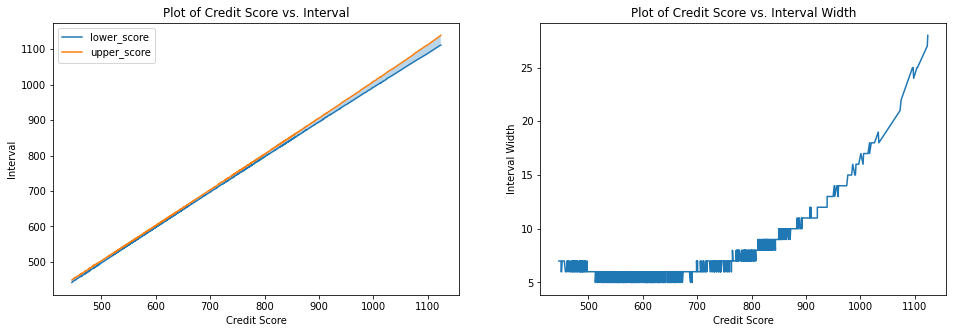

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

axs[0].plot(df_distinct['score'], df_distinct['lower_score'], label='lower_score')
axs[0].plot(df_distinct['score'], df_distinct['upper_score'], label='upper_score')

axs[0].fill_between(df_distinct['score'], df_distinct['lower_score'], df_distinct['upper_score'], alpha=0.3)

axs[0].set_xlabel('Credit Score')
axs[0].set_ylabel('Interval')
axs[0].set_title('Plot of Credit Score vs. Interval')
axs[0].legend()

width_values = df_distinct['upper_score'] - df_distinct['lower_score']
axs[1].plot(df_distinct['score'], width_values)
axs[1].set_xlabel('Credit Score')
axs[1].set_ylabel('Interval Width')
axs[1].set_title('Plot of Credit Score vs. Interval Width')

plt.show()

The interval width is increasing with the growth of credit score. So the people with low credit score seems more stable.

In [116]:
df['width'] = df['upper_score']-df['lower_score']
df['target'] = df['label'].map(score_mapping)
df.head()

,lower_score,score,upper_score,label,probability,width,target
22670,842,846,851,Standard,0.894701,9,1
1811,828,833,837,Standard,0.882789,9,1
59820,799,803,807,Good,0.853201,8,1
22348,842,846,851,Standard,0.894701,9,1
77856,977,984,992,Standard,0.965561,15,1


In [117]:
width_percentiles = [np.percentile(df['width'], p) for p in range(0, 101, 5)]
print('Percentile list of the credit width: ',width_percentiles)
width_mapping = {5:'5', 6:'6', 7:'7',8:'8',9:'9',10:'10',11:'11-28',12:'11-28',13:'11-28',14:'11-28',15:'11-28',16:'11-28',17:'11-28',18:'11-28',19:'11-28',20:'11-28',21:'11-28',22:'11-28',23:'11-28',24:'11-28',25:'11-28',26:'11-28',27:'11-28',28:'11-28'}
df['width_class'] = df['width'].map(width_mapping)
# use 0.5 as the threshold
df['pred'] = df['probability'].apply(lambda x: 1 if x > 0.5 else 0)
df.head()

Percentile list of the credit width:  [5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 8.0, 8.0, 8.0, 9.0, 9.0, 10.0, 10.0, 24.0, 25.0, 28.0]


,lower_score,score,upper_score,label,probability,width,target,width_class,pred
22670,842,846,851,Standard,0.894701,9,1,9,1
1811,828,833,837,Standard,0.882789,9,1,9,1
59820,799,803,807,Good,0.853201,8,1,8,1
22348,842,846,851,Standard,0.894701,9,1,9,1
77856,977,984,992,Standard,0.965561,15,1,11-28,1


In [118]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

grouped_df = df.groupby('width_class').agg({'width_class': 'count'})
grouped_df['PositiveRatio'] = grouped_df.apply(lambda row: df[df['width_class'] == row.name]['target'].mean(), axis=1)
grouped_df['Accuracy'] = grouped_df.apply(lambda row: accuracy_score(df[df['width_class'] == row.name]['target'], df[df['width_class'] == row.name]['pred']), axis=1)
grouped_df['Recall'] = grouped_df.apply(lambda row: recall_score(df[df['width_class'] == row.name]['target'], df[df['width_class'] == row.name]['pred']), axis=1)
grouped_df['Precision'] = grouped_df.apply(lambda row: precision_score(df[df['width_class'] == row.name]['target'], df[df['width_class'] == row.name]['pred']), axis=1)

print(grouped_df)

             width_class  PositiveRatio  Accuracy    Recall  Precision
width_class                                                           
10                   734       0.944142  0.944142  1.000000   0.944142
11-28               1279       0.996873  0.996873  1.000000   0.996873
5                    810       0.532099  0.635802  0.837587   0.616041
6                   2812       0.398293  0.690967  0.589286   0.617399
7                    851       0.573443  0.819036  0.838115   0.845041
8                   1389       0.871850  0.871850  1.000000   0.871850
9                   1047       0.885387  0.885387  1.000000   0.885387


Basically, the longer width corresponds better metrics outcome. But that's because the samples have long intervals are all positive, and the model prefer to predict a sample as positive because the unbalanced label ratio.

We can try to smote the sample then repulicate the analysis

In [119]:
#X_train_sampled, _, y_train_sampl, _ = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

#explainer = shap.Explainer(ngb.predict, X_train_sampled)
#shap_values = explainer(X_train_sampled)
#shap.summary_plot(shap_values, X_train_sampled)

In [128]:
index = [6,11,9,41,7,10,43,13,5,0,42,4,46,15,3,16,8,23,2,29]
Important_features = [f for i,f in enumerate(X.columns) if i in index]
Important_features = sorted(Important_features,key=lambda x: index.index(list(X.columns).index(x)))
print(Important_features)

['Interest_Rate', 'Outstanding_Debt', 'Changed_Credit_Limit', 'Credit_Mix_Bad', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Credit_Mix_Standard', 'Credit_History_Age', 'Num_Credit_Card', 'Month', 'Credit_Mix_Good', 'Num_Bank_Accounts', 'Spent Amount Payment_Behaviour', 'Amount_invested_monthly', 'Monthly_Inhand_Salary', 'Monthly_Balance', 'Num_of_Delayed_Payment', 'Count_Student Loan', 'Annual_Income', 'Occupation_Doctor']


The importance rank of the features are not surprising, top features are highly related to the credit behaviours.

## Conformal Prediction

### Training

In [121]:
# Uncertainty quantification for classification problem
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

from mapie.classification import MapieClassifier

# Using LightGBM as the base learner
classifier = lgb.LGBMClassifier(verbose=0)#LogisticRegression() perform not well #NGBClassifier() can't be used here

mapie_classifier = MapieClassifier(estimator=classifier, method='score', cv=5)

mapie_classifier = mapie_classifier.fit(X_train, y_train)
y_pred, y_pis = mapie_classifier.predict(X_test, alpha=0.05)

# Using Logistic Regression as the base learner
classifier2 = LogisticRegression()# perform not well #NGBClassifier() can't be used here

mapie_classifier2 = MapieClassifier(estimator=classifier2, method='score', cv=5)

mapie_classifier2 = mapie_classifier2.fit(X_train, y_train)
y_pred2, y_pis2 = mapie_classifier2.predict(X_test, alpha=0.05)

print(y_pred[:10])

[1 1 1 1 1 1 1 1 1 1]


Conformal Prediction packages like mapie can't offer probabilities for classification task, it only focus on the possible categories set.

### Comparative analysis

In [122]:
#print(y_pred[:10],y_pis[:10]) #no probability
y_ng, pred_ng = df['target'], df['pred']
print('When drived from LightGBM')
print('Accuracy:\n', f'CP(LGBM): {accuracy_score(y_test,y_pred):.2f}',',',f'CP(Logistic): {accuracy_score(y_test,y_pred2):.2f}',',', f'NGBoost: {accuracy_score(y_ng,pred_ng):.2f}')
print('Precision:\n', f'CP(LGBM): {precision_score(y_test,y_pred):.2f}',',',f'CP(Logistic): {precision_score(y_test,y_pred2):.2f}',',', f'NGBoost: {precision_score(y_ng,pred_ng):.2f}')
print('Recall:\n', f'CP(LGBM): {recall_score(y_test,y_pred):.2f}',',',f'CP(Logistic): {recall_score(y_test,y_pred2):.2f}',',', f'NGBoost: {recall_score(y_ng,pred_ng):.2f}')

When drived from LightGBM
Accuracy:
 CP(LGBM): 0.83 , CP(Logistic): 0.76 , NGBoost: 0.81
Precision:
 CP(LGBM): 0.86 , CP(Logistic): 0.78 , NGBoost: 0.84
Recall:
 CP(LGBM): 0.89 , CP(Logistic): 0.90 , NGBoost: 0.90


The outcome of conformal prediction is heavily depended on the base model we choose. When we use some strong models like LGBM, it can  outperform than the NGBoost.

In [123]:
def prob_map(p):
    if p>= 0.95:
        return 'True'
    if p<=0.05:
        return 'False'
    return p

CP_lgbm_set = [str(y[0][0]) if y[0][0]==y[1][0] else 'Both' for y in y_pis]
CP_logistic_set = [str(y[0][0]) if y[0][0]==y[1][0] else 'Both' for y in y_pis2]
NGB_set = [prob_map(p) if (p>=0.95 or p<=0.05) else 'Both' for p in df['probability']]


from collections import Counter
counts = [Counter(lst) for lst in [CP_lgbm_set, CP_logistic_set, NGB_set]]

data_count = {'Both': [count['Both'] for count in counts],
              'True': [count['True'] for count in counts],
              'False': [count['False'] for count in counts]}

df_count = pd.DataFrame(data_count, index=['CP_lgbm_set', 'CP_logistic_set', 'NGB_set'])

df_count.head()

,Both,True,False
CP_lgbm_set,5114,3808,0
CP_logistic_set,3784,5138,0
NGB_set,7694,1228,0


This table describes the how many samples are believed must be True/False or both are possible under 95% confidence level by three methods. NGBoost doesn't give the possible set directly. But since we assume the y follows a Bernoulli distribution, if the 'p' is upper 0.95 or under 0.05, the possible outcome will shrink to 1 or 0 under 95% confidence level, otherwise we have to say both are possible. However, I don't think those two different methods have the same guarantees on how they define and generate the possible set or intervals, so the comparation is not totally fair.

From the table, we can see no sample is recognized pure False, again it may because the unbalanced of labels. And for the Both and True, NGBoost gives the least pure True prediction. But it can hardly say NGBoost is more uncertainly, since there are only two possible label. Chosing Both can only indicate this model dislikes to give an extrem prediction.

However, the two conformal prediction methods give the prediction set doesn't totally rely on the base model's predictive probability, so maybe we can think the LGBM Conformal Prediction has higher uncertainty, though it has better performance as well.

In [124]:
import pickle

# Assuming 'ngb' is your trained NGBoost model
with open('credit_score_model.pkl', 'wb') as file:
    pickle.dump(ngb, file)

print("Model saved as credit_score_model.pkl")


Model saved as credit_score_model.pkl


In [125]:
import pickle
import numpy as np

# Load the model from the pkl file
with open('credit_score_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Verify the model is loaded correctly
print("Model loaded successfully!")

# Test the loaded model by making predictions
# Assuming X_test is already defined and preprocessed
predicted_probs = loaded_model.predict_proba(X_test)
predicted_labels = loaded_model.predict(X_test)

# Print some predictions for verification
print("Predicted probabilities for the first 5 samples:", predicted_probs[:5])
print("Predicted labels for the first 5 samples:", predicted_labels[:5])

# Optionally, evaluate the model's performance on the test set
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, predicted_probs[:, 1])
print("The AUC on the test set using the loaded model is:", roc_auc)


Model loaded successfully!
Predicted probabilities for the first 5 samples: [[0.1052993  0.8947007 ]
 [0.1172107  0.8827893 ]
 [0.14679918 0.85320082]
 [0.1052993  0.8947007 ]
 [0.03443906 0.96556094]]
Predicted labels for the first 5 samples: [1 1 1 1 1]
The AUC on the test set using the loaded model is: 0.860025965936044
